<a href="https://colab.research.google.com/github/Iasonaspg/ser-repo/blob/main/SER_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Emotions/')
!ls 

anger  disgust	fear  happiness  sadness


In [3]:
!python -m pip install -U pip
!pip uninstall librosa
!pip install librosa

import numpy as np
import scipy
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

     |████████████████████████████████| 1.5MB 9.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Found existing installation: librosa 0.6.3
Uninstalling librosa-0.6.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/librosa-0.6.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/librosa/*
Proceed (y/n)? y
  Successfully uninstalled librosa-0.6.3
     |████████████████████████████████| 183 kB 5.6 MB/s 
     |████████████████████████████████| 51 kB 355 kB/s 
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201376 sha256=b45b081c0f6f2a6dbd8753755dc8e009c9465b542b26d08551a9ab48b03c6f4a
  Stored in directory: /root/.cache/pip/wheels/32/2c/ce/86e49d4769aceba728421c24c0d726054bf4ca01175ff42bdd
Successfully built librosa


In [4]:
print(librosa.__version__)

0.8.0


In [5]:
# load audio file
from pathlib import Path
fs = 22050
n_fft, hop = 1024, 256

# Fucntions require you to be in the root data directory
def get_train_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/train' + '/*.wav') ]

def get_test_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/test' + '/*.wav') ]



emotions = ["sadness","happiness","anger","fear","disgust"]

# list of len(emotions) that contains lists of numpy arrays. Each numpy array belongs to a single wav file
train_wav = []
test_wav = []
for emotion in emotions:
  train_wav.append(get_train_wav_dir(emotion,fs))
  test_wav.append(get_test_wav_dir(emotion,fs))




In [6]:
from numpy import genfromtxt

os.chdir('/content/drive/My Drive/Br_CSV/')


br_train = []
br_test = []
for emotion in emotions:
  filename = 'br_' + emotion + '_train.csv'
  temp = genfromtxt(filename,delimiter=',')
  np.nan_to_num(temp,copy=False)
  br_train.append(temp)
  filename = 'br_' + emotion + '_test.csv'
  temp = genfromtxt(filename,delimiter=',')
  np.nan_to_num(temp,copy=False)
  br_test.append(temp)



print(br_train[0].shape)
print(br_train[1].shape)
print(br_train[2].shape)
print(br_train[3].shape)
print(br_train[4].shape)


(2, 32013)
(2, 28208)
(2, 25665)
(2, 27131)
(2, 34553)


In [ ]:
for i in range(len(train_wav)):
  for j in range(len(train_wav[i])):
    train_wav[i][j], _ = librosa.effects.trim(train_wav[i][j],top_db=15,frame_length=128,hop_length=32)
    #display(Audio(i, rate=fs))
    #plt.plot(i)
    #plt.show()
    #plt.plot(i_t)
    #plt.show()

for i in range(len(test_wav)):
  for j in range(len(test_wav[i])):
    test_wav[i][j], _ = librosa.effects.trim(test_wav[i][j],top_db=15,frame_length=128,hop_length=32)

# print(index)
plt.plot(train_wav[0][0])
plt.plot(train_wav[2][7])

In [ ]:
display(Audio(train_wav[0][0], rate=fs))
print(train_wav[1][0].shape)

In [7]:
from librosa.feature import spectral

# Gets a list of wav signals and returns a numpy array of features x nFrames_total and a list of len(input) containing the nFrames per signal
def extract_features(wav):
  spectral_centroid = spectral.spectral_centroid(wav[0], sr=fs, n_fft=n_fft, hop_length=hop, center=False)
  spectral_rolloff = spectral.spectral_rolloff(wav[0], sr=fs, n_fft=n_fft, hop_length=hop,roll_percent=0.30, center=False)
  zero_crossing_rate = spectral.zero_crossing_rate(wav[0], frame_length=n_fft, hop_length=hop, center=False)
  mfcc = librosa.feature.mfcc(wav[0], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7, center=False)
  desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[4:5,:],mfcc[6:7,:]),axis=0)
  mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
  mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
  feature_vector = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate,desired_mfcc,mfcc_delta,mfcc_delta2),axis=0)
  nFrames = [0 for i in range(len(wav))]
  nFrames[0] = spectral_centroid.shape[1]
  for i in range(1,len(wav)):
    cols = wav[i].shape[0]
    spectral_centroid = spectral.spectral_centroid(wav[i], sr=fs, n_fft=n_fft, hop_length=hop, center=False)
    spectral_rolloff = spectral.spectral_rolloff(wav[i], sr=fs, n_fft=n_fft, hop_length=hop,roll_percent=0.30, center=False)
    zero_crossing_rate = spectral.zero_crossing_rate(wav[i], frame_length=n_fft, hop_length=hop, center=False)
    mfcc = librosa.feature.mfcc(wav[i], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7, center=False)
    desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[4:5,:],mfcc[6:7,:]),axis=0)
    mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
    mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
    feature_vector1 = np.concatenate((spectral_centroid,spectral_rolloff,zero_crossing_rate,desired_mfcc,mfcc_delta,mfcc_delta2),axis=0)
    feature_vector = np.concatenate((feature_vector,feature_vector1),axis=1)
    nFrames[i] = spectral_centroid.shape[1]
  return feature_vector, nFrames


test_nframes = []
train_nframes = []
feature_train_vector, _ = extract_features(train_wav[0])
label_vec = [0 for i in range(feature_train_vector.shape[1])]
feature_train_vector = np.concatenate((feature_train_vector,br_train[0],np.array([label_vec])),axis=0)

feature_test_vector, test_nframe = extract_features(test_wav[0])
label_vec = [0 for i in range(feature_test_vector.shape[1])]
feature_test_vector = np.concatenate((feature_test_vector,br_test[0],np.array([label_vec])),axis=0)
test_nframes.append(test_nframe)
for i in range(1,len(train_wav)):
  train_feat_vec, train_nframe = extract_features(train_wav[i])
  train_nframes.append(train_nframe)
  label_vec = [i for j in range(train_feat_vec.shape[1])]
  train_feat_vec = np.concatenate((train_feat_vec,br_train[i],np.array([label_vec])),axis=0)
  feature_train_vector = np.concatenate((feature_train_vector,train_feat_vec),axis=1)

  
  test_feat_vec, test_nframe = extract_features(test_wav[i])
  test_nframes.append(test_nframe)
  label_vec = [i for j in range(test_feat_vec.shape[1])]
  test_feat_vec = np.concatenate((test_feat_vec,br_test[i],np.array([label_vec])),axis=0)
  feature_test_vector = np.concatenate((feature_test_vector,test_feat_vec),axis=1)


print(feature_test_vector.shape)
#print(happy_train_feat_vec.shape)
print('=')
print(feature_train_vector.shape)
#print(feature_vector[:,0:2])

(15, 25205)
=
(15, 147570)


In [14]:
print(feature_train_vector[:,131130])

[ 5.94429251e+03  4.90957031e+03  5.41992188e-01 -1.18576645e+02
 -1.97425385e+01 -9.49008369e+00 -1.35814381e+01 -4.55100155e+00
 -6.36391401e-01  7.51859760e+00 -5.49362935e-02  1.70328379e-01
  9.94840000e-01  9.90660000e-01  4.00000000e+00]


In [21]:
import pandas as pd
index = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13"]
feat_train = feature_train_vector[0:14,:]

pd_feat_train = pd.DataFrame(feat_train.T)
pd_feat_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000
mean,2466.849859,1094.105888,0.135340,69.904337,-5.913831,-12.793342,-0.000116,0.023334,-0.012004,0.005912,-0.002650,0.001906,0.840143,0.667034
std,1568.838165,1447.979581,0.147026,63.951290,27.270888,20.128150,10.570079,3.965490,2.929460,5.122999,2.014720,1.662102,0.199235,0.237168
min,26.587444,0.000000,0.000000,-235.525085,-149.226013,-100.508789,-45.974712,-20.612913,-14.117944,-25.144709,-10.745960,-7.945780,0.000000,0.000000
25%,1408.982815,322.998047,0.045898,37.315625,-22.989209,-25.982828,-5.185256,-2.336780,-1.812250,-2.983755,-1.236926,-1.023916,0.775510,0.512320
50%,1956.965492,495.263672,0.076172,79.371826,-5.786995,-11.890460,-0.186710,0.075184,0.035244,-0.151757,-0.001493,-0.002288,0.907740,0.697565
75%,2956.028462,968.994141,0.150391,113.570728,11.082223,1.120397,5.244794,2.453499,1.856264,2.622996,1.208461,1.027122,0.980080,0.864457
max,8398.838795,8161.083984,0.805664,251.672791,115.711357,81.680939,53.939419,19.865591,13.983083,26.298500,10.816760,9.126064,0.999950,0.999920


In [15]:
a = np.asarray(feature_train_vector)
np.savetxt("feature_train_vector.csv", a, delimiter=",")

a = np.asarray(feature_test_vector)
np.savetxt("feature_test_vector.csv", a, delimiter=",")

In [ ]:
import os
import pandas as pd
os.chdir('/content/drive/My Drive/Br_CSV/')

feature_train_vector = np.genfromtxt("feature_train_vector.csv", delimiter=",")
feature_test_vector = np.genfromtxt("feature_test_vector.csv", delimiter=",")
print(feature_train_vector.shape)

In [ ]:
import sklearn
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

X_train = feature_train_vector[0:14,:].T
Y_train = feature_train_vector[14,:].T

X_test = feature_test_vector[0:14,:].T
Y_test = feature_test_vector[14,:].T

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler.fit(X_test)
X_test = scaler.transform(X_test)

pca = sklearn.decomposition.PCA(n_components=14)
pca_train = pca.fit_transform(X_train)




# fig, axes = plt.subplots(1,2)
# axes[0].scatter(feature_train_vector[3:4,:].T, feature_train_vector[12:13,:].T, c=feature_train_vector[14,].T)
# axes[0].set_xlabel('x1')
# axes[0].set_ylabel('x2')
# axes[0].set_title('Before PCA')
# axes[1].scatter(pca_train[3:4,:], pca_train[12:13,:], c=feature_train_vector[14,].T)
# axes[1].set_xlabel('PC1')
# axes[1].set_ylabel('PC2')
# axes[1].set_title('After PCA')
# plt.show()



In [ ]:
print(pca.explained_variance_ratio_,"\n")
#print(pca.explained_variance_)
print(abs( pca.components_ )[0],"\n")
print(abs( pca.components_ )[1],"\n")
print(abs( pca.components_ )[2],"\n")


In [9]:
from joblib import dump, load
from sklearn import svm
import time


X_train = feature_train_vector[0:14,:].T
Y_train = feature_train_vector[14,:].T
Y_test = feature_test_vector[14,:].T
X_test = feature_test_vector[0:14,:].T

clf = svm.SVC(C=1.0)
str = time.time()
clf.fit(X_train, Y_train)
print(time.time()-str)

dump(clf, './svm_raw14_c1.joblib') 

1830.6374039649963


['./svm_raw14_c1.joblib']

In [ ]:
from joblib import dump, load
from sklearn import svm

clf = load('./svm_model.joblib')

In [12]:
import statistics 
from statistics import mode,mean

def get_label(y):
  return mode(y)



In [ ]:
from sklearn.metrics import accuracy_score

print("CPU: \n")

accuracy_list = []


Y_test = feature_test_vector[14,:].T
X_test = feature_test_vector[0:14,:].T

i = 0
for k in test_nframes:
  for j in k:
    pred = clf.predict(X_test[i:i+j,:])
    try:
      val = mode(pred)
    except:
      val = round(mean(pred))
    acc = accuracy_score(Y_test[i:i+j,],pred,True)
    accuracy_list.append(acc)
    print(acc)
    i = i + j

print("Mean CPU accuracy: ", np.mean(accuracy_list))

In [ ]:
pred = clf.predict(X_test)
print(metrics.classification_report(Y_test, pred, digits=3))

In [13]:
from sklearn import metrics
#from sklearn.metrics import accuracy_score

Y_test = feature_test_vector[14,:].T
X_test = feature_test_vector[0:14,:].T

print("CPU: \n")

accuracy_list = []
y_pred = []
y_true = []

i = 0
label = 0
for k in test_nframes:
  for j in k:
    pred = clf.predict(X_test[i:i+j,:])
    try:
      val = mode(pred)
    except:
      #print(pred)
      val = round(mean(pred))
    y_pred.append(val)
    y_true.append(label)
    i = i + j
  label = label + 1

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

CPU: 

[[15  0  0  0  3]
 [ 4  0  0  1 12]
 [ 4  0  3  0 11]
 [ 7  0  1  0  9]
 [ 2  0  0  0 16]]
              precision    recall  f1-score   support

           0      0.469     0.833     0.600        18
           1      0.000     0.000     0.000        17
           2      0.750     0.167     0.273        18
           3      0.000     0.000     0.000        17
           4      0.314     0.889     0.464        18

    accuracy                          0.386        88
   macro avg      0.306     0.378     0.267        88
weighted avg      0.313     0.386     0.273        88



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train = np.concatenate((feature_train_vector[0:2,:],feature_train_vector[5:10,:]),axis=0).T
Y_train = np.concatenate((feature_test_vector[0:2,:],feature_test_vector[5:10,:]),axis=0).T


clf_lgr = LogisticRegression(C=1,random_state=0,solver='liblinear',max_iter=200)
clf_lgr.fit(X_train, feature_train_vector[14,:].T)
clf_lgr.predict(Y_train)
print(clf_lgr.score(X_train, feature_train_vector[14,:].T))

pred = clf_lgr.predict(Y_train)
print(accuracy_score(feature_test_vector[14,:].T,pred,True))

0.29077048180524495
0.3004959333465582


In [ ]:
print("CPU: \n")

Y_test = np.concatenate((feature_test_vector[3:4,:],feature_test_vector[6:7,:],feature_test_vector[1:2,:]),axis=0)

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(Y_train[i:i+j,:])
    acc = accuracy_score(feature_test_vector[14,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_vector[0:8,i:i+j].T,feature_test_vector[8,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.5884674780428626


In [ ]:
print("CPU: \n")

accuracy_list = []

for k in train_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_train_vector[0:12,i:i+j].T)
    acc = accuracy_score(feature_train_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_vector[0:12,i:i+j].T,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.6403572724437385


In [ ]:
print("CPU: \n")

accuracy_list = []

for k in test_nframes:
  i = 0
  for j in k:
    pred = clf_lgr.predict(feature_test_norm[i:i+j,])
    acc = accuracy_score(feature_test_vector[12,i:i+j].T,pred,True)
    #acc = clf_lgr.score(feature_test_norm,feature_test_vector[12,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.5776524845968057


In [ ]:
def spectrogram(wav,n_fft=256,hop_length=128,window='hamming'):
    D = librosa.stft(wav, n_fft, hop_length, window='hamming')
    spect, _ = librosa.magphase(D, power=1)
    return spect

spec = spectrogram(wav,256)

print('Spectrogram shape', spec.shape)
print('{min %.2f} {mean %.2f} {max %.2f}' % (np.amin(spec), np.mean(spec), np.amax(spec)))
plt.plot(wav)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(spec, origin='lower')
plt.show()

plt.hist(spec)
plt.show()

log_spec = librosa.power_to_db(spec ** 2, ref=np.min)
plt.figure(figsize=(10,10))
plt.imshow(log_spec, origin='lower',vmin=-60)
plt.show()
plt.hist(log_spec)
plt.xlabel('Magnitude (dB)')
plt.show()

In [ ]:
print(n_fft)
print(hop)
x_train_sp = []
train_labels = []
k = 0
for i in train_wav:
  for j in i:
    mel_sp = librosa.feature.melspectrogram(j, sr=fs, n_fft=2048, hop_length=1024, n_mels=64, power=1.0, fmin=10., fmax=4000.)
    pad_width = 64 - mel_sp.shape[1]
    mel_sp = librosa.amplitude_to_db(mel_sp)
    if (pad_width > 0):
      mel_sp = np.pad(mel_sp, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mel_sp = mel_sp[:,0:64]
    print(mel_sp.shape)
    x_train_sp.append(mel_sp)
    train_labels.append(k)
  k = k + 1

k = 0
x_test_sp = []
test_labels = []
for i in test_wav:
  for j in i:
    mel_sp = librosa.feature.melspectrogram(j, sr=fs, n_fft=2048, hop_length=512, n_mels=64, power=1.0, fmin=10., fmax=4000.)
    pad_width = 64 - mel_sp.shape[1]
    mel_sp = librosa.amplitude_to_db(mel_sp)
    if (pad_width > 0):
      mel_sp = np.pad(mel_sp, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mel_sp = mel_sp[:,0:64]
    x_test_sp.append(mel_sp)
    test_labels.append(k)
  k = k + 1


x_train = np.asarray(x_train_sp)
x_test = np.asarray(x_test_sp)

#display(Audio(train_wav[0][0],fs))
#display(Audio(x_train_sp[0][0],fs))
print(x_train.shape)

In [ ]:
mel_sp_npar.shape[1:]

(804, 804)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 2053)              8411141   
_________________________________________________________________
dense_44 (Dense)             (None, 2053)              4216862   
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 10270     
Total params: 12,638,273
Trainable params: 12,638,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
6/6 - 0s - loss: 671.1204 - accuracy: 0.2327 - val_loss: 1211.6531 - val_accuracy: 0.0000e+00
Epoch 2/30
6/6 - 0s - loss: 149.2153 - accuracy: 0.3241 - val_loss: 279.6701 - val_accuracy: 0.3290
Epoch 3/30
6/6 - 0s - loss: 36.116

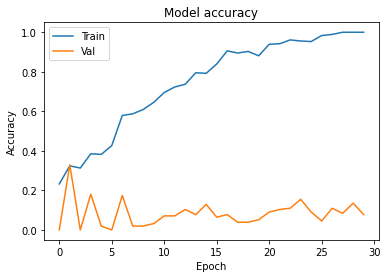

3/3 [==============================] - 0s 3ms/step - loss: 11.0038 - accuracy: 0.3409
Evaluation accuray 0.34090909361839294 loss: 11.003780364990234


In [ ]:
import sklearn.preprocessing
import tensorflow as tf
import keras
from keras.layers import *



# define model
n_frames = x_train.shape[1]
n_features = x_train.shape[2]
num_classes = 5


mlp = keras.Sequential() 
mlp.add(Flatten(input_shape=x_train.shape[1:]))
mlp.add(Dense(num_classes+(n_frames*n_features)//2, activation='relu'))
mlp.add(Dense(num_classes+(n_frames*n_features)//2, activation='relu'))
mlp.add(Dense(num_classes, activation='softmax'))

mlp.summary()

# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = mlp.fit(x=x_train, y=keras.utils.to_categorical(train_labels), batch_size=64, epochs=30, verbose=2, validation_split=0.3)

# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

loss, acc = mlp.evaluate(x_test, keras.utils.to_categorical(test_labels))
print('Evaluation accuray', acc,'loss:', loss)